# Kenyan Food Classification - Exploratory Data Analysis (EDA)

This notebook explores the dataset for the Kenyan Food Classification Kaggle competition. We will:
- Count the occurrences of each label/class
- Visualize sample images per class
- Test and visualize augmentations using Albumentations

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np

# For augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import  transforms as T


In [2]:
# Load the CSV and inspect label distribution
csv_path = 'data/train.csv'  # Adjust if needed
img_dir = 'data/images/images'  # Adjust if needed

df = pd.read_csv(csv_path)
df.head()

id       class
0  14278962987112149800     githeri
1  13190220095752321996       ugali
2  10431803432626641638  kachumbari
3   4222441716327528413     githeri
4   2547906925836120627      matoke

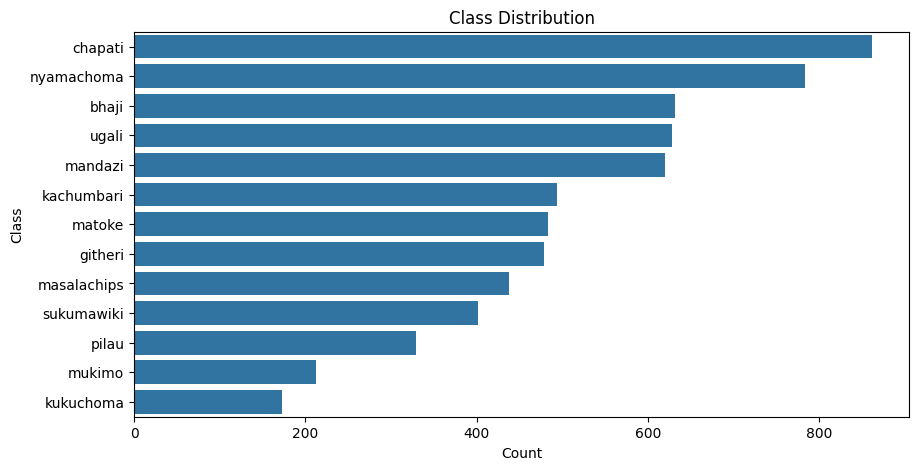

In [3]:
# Count occurrences of each label
plt.figure(figsize=(10,5))
sns.countplot(y=df.iloc[:,1], order=df.iloc[:,1].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

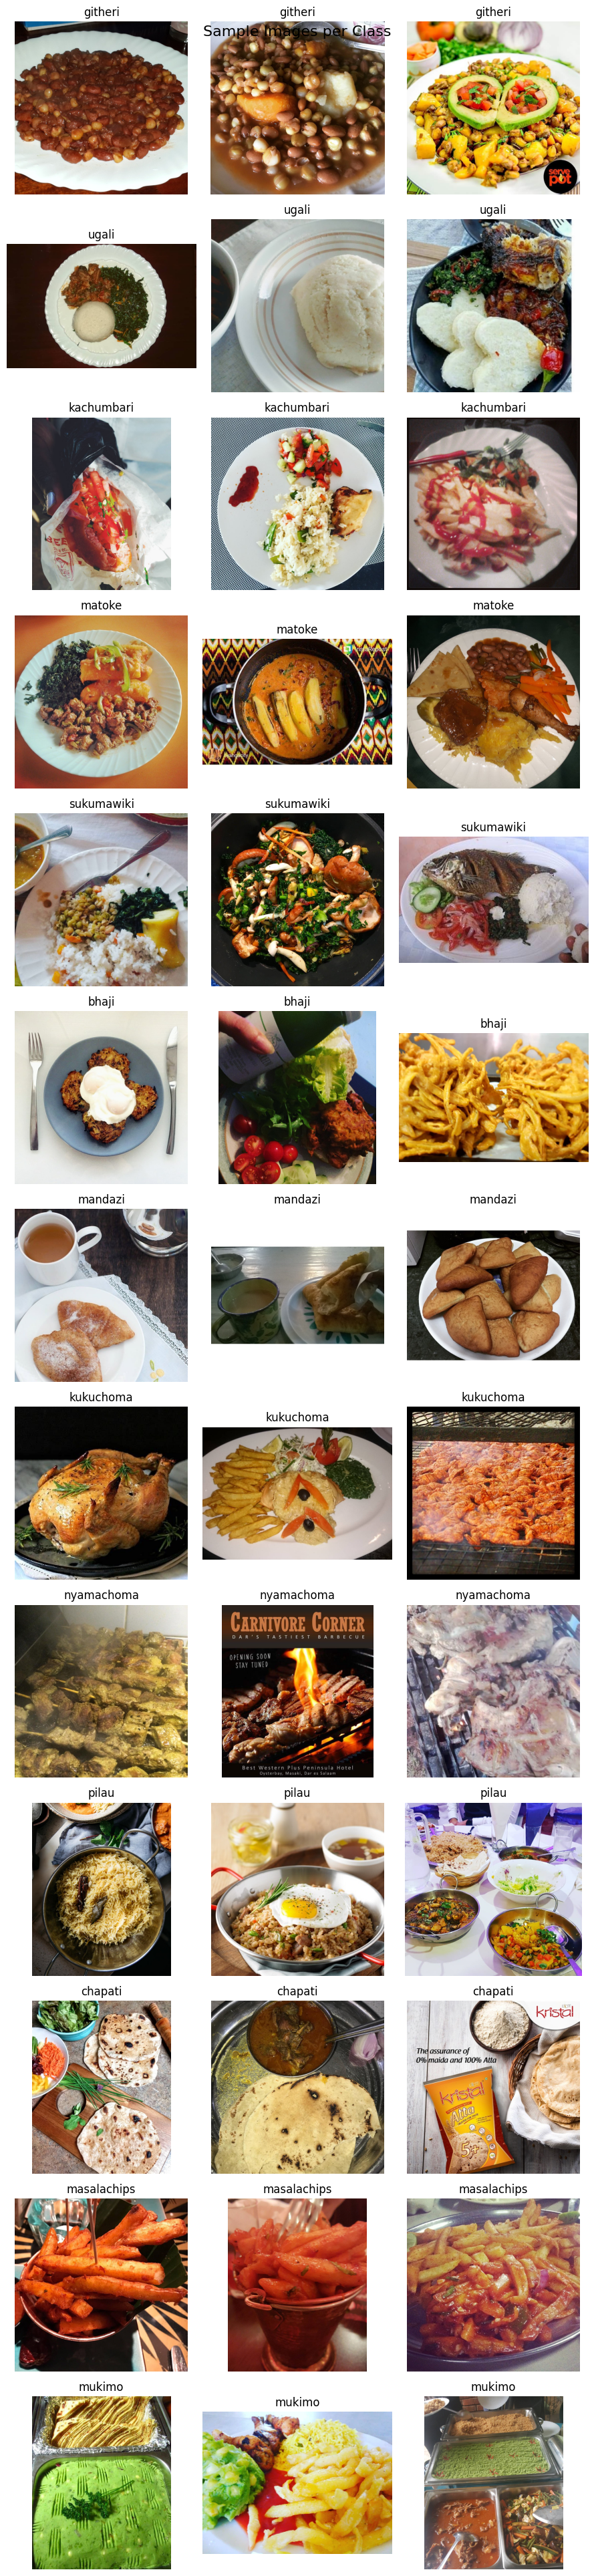

In [4]:
# Show a few images per class
classes = df.iloc[:,1].unique()
num_classes = len(classes)
num_samples = 3

plt.figure(figsize=(num_samples*3, num_classes*3))
for i, cls in enumerate(classes):
    sample_imgs = df[df.iloc[:,1]==cls].sample(num_samples, random_state=42)
    for j, img_name in enumerate(sample_imgs.iloc[:,0]):
        img_path = os.path.join(img_dir, str(img_name) + '.jpg' if not str(img_name).endswith('.jpg') else str(img_name))
        img = Image.open(img_path)
        plt.subplot(num_classes, num_samples, i*num_samples + j + 1, title = cls)
        plt.imshow(img)
        plt.axis('off')
        if j == 0:
            plt.ylabel(cls, fontsize=12)
plt.suptitle('Sample Images per Class', fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
df

id       class
0     14278962987112149800     githeri
1     13190220095752321996       ugali
2     10431803432626641638  kachumbari
3      4222441716327528413     githeri
4      2547906925836120627      matoke
...                    ...         ...
6531   9491780363201908054      matoke
6532    938716700684692863     chapati
6533  12487998559342412135       ugali
6534   3466916091782561952  kachumbari
6535   4410319397208590457     chapati

[6536 rows x 2 columns]

In [6]:
df.iloc[2,0]


np.uint64(10431803432626641638)

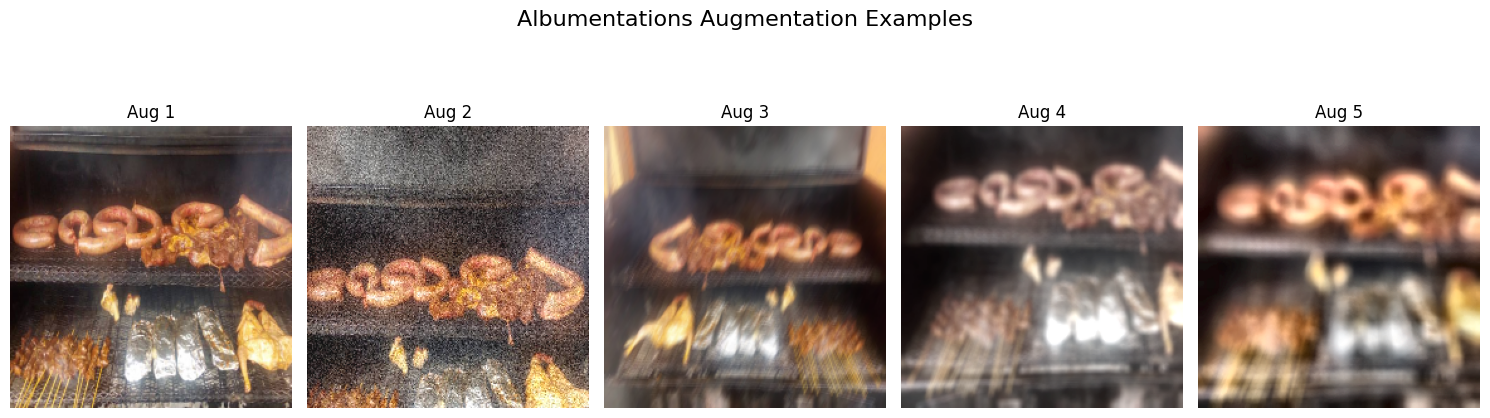

In [10]:




# Visualize augmentations for a random image
img_name = df.iloc[8,0] # Change the first index to visualize a different image 
img_path = os.path.join(img_dir, str(img_name) + '.jpg' if not str(img_name).endswith('.jpg') else str(img_name))
img = np.array(Image.open(img_path).convert('RGB'))


pipeline = A.Compose([
    
    # First, resize
    A.OneOf([
        
        A.Compose([
            A.Resize(height=300, width=300),
            A.RandomCrop(height=224, width=224)]),
        
        A.Compose([
            A.RandomCrop(height=300, width=300),
            A.Resize(height=224, width=224)
        ]),
        
        A.Resize(height=224, width=224)
        
    ], p = 1.0),
    
    
    # Second, noise or blur
    A.OneOf([
        A.AdditiveNoise(
            noise_type="gaussian",
            spatial_mode="shared",
            noise_params={"mean_range":[0,0],"std_range":[0.05,0.15]},
            approximation=1), 
        
        A.Blur(
        blur_limit=[3, 7]
        ),
        
        A.Defocus(
            radius=[3, 6],
            alias_blur=[0.1, 0.5]
        ),
        
        A.GaussNoise(
            std_range=[0.1, 0.2],
            mean_range=[0, 0],
            per_channel=True,
            noise_scale_factor=0.2
        ),
        
        A.GlassBlur(
            sigma=0.3,
            max_delta=3,
            iterations=2,
            mode="fast"
        ),
        
        A.MotionBlur(
            blur_limit=[5, 10],
            allow_shifted=False,
            angle_range=[0, 90],
            direction_range=[-1, 1]
        )
    ], p = 0.75),
    
    # Flips
    A.HorizontalFlip(p=0.5),

    
    # HSL adjustments
    A.OneOf([
        A.CLAHE(
            clip_limit=4,
            tile_grid_size=[8, 8]
        ),
        
        A.RandomBrightnessContrast(
            brightness_limit=[-0.3, 0.3],
            contrast_limit=[-0.3, 0.3],
            brightness_by_max=True,
            ensure_safe_range=False
        ),
        
        A.ColorJitter(
            brightness=[0.8, 1.2],
            contrast=[0.8, 1.2],
            saturation=[0.4, 0.6],
            hue=[-0.05, 0.05]
        )
        
    ], p = 0.75)
])

plt.figure(figsize=(15,5))
for i in range(5):
    augmented = pipeline(image=img)['image']
    plt.subplot(1,5,i+1)
    plt.imshow(augmented)
    plt.axis('off')
    plt.title(f'Aug {i+1}')
plt.suptitle('Albumentations Augmentation Examples', fontsize=16)
plt.tight_layout()
plt.show()